<a href="https://colab.research.google.com/github/TsukaMizu/Pilotttt/blob/main/ProcessMining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pm4py
!pip install openpyxl
# Upload file
from google.colab import files
uploaded = files.upload()

Saving tps_Juli2021.xlsx to tps_Juli2021 (1).xlsx
Saving tps_Agustus2021.xlsx to tps_Agustus2021 (1).xlsx
Saving tps_September2021.xlsx to tps_September2021 (1).xlsx


In [ ]:
import pandas as pd
import pm4py

In [ ]:
# Baca semua file yang diupload
file_paths = [f for f in uploaded.keys() if f.endswith('.xlsx')]
dataframes = [pd.read_excel(f) for f in file_paths]


In [ ]:
# Gabungkan
df = pd.concat(dataframes, ignore_index=True)
df.head()

,CONTAINER_KEY,CTR_SIZE,CTR_TYPE,GROSS,VESSEL_ATB,BAPLIE_TS,DISC_DATE,YARD_BLOCK,YARD_SLOT,STACK_DATE,...,TRUCK_IN_DATE,UNSTACK_TO_TRUCK,TRUCK_OUT_DATE,SP_JALUR_MERAH_PIB_DATE,CUSTOMS_BEHANDLE_COUNT,FIRST_JOB_CUSTOMS_BEHANDLE_TS,FIRST_STACK_BEHANDLE_TS,LAST_COMPLETE_BEHANDLE_TS,STACK_TRK_BF_MAIN_YARD_TS,STACK_MAIN_YARD_TS
0,AAAU9001220,40,DRY,12.20,2021-06-28 20:00:00,2021-06-27 11:09:00,2021-06-28 22:22:00,N,98.0,2021-06-28 22:40:00,...,2021-07-06 06:33:00,2021-07-06 06:43:00,2021-07-06 06:51:00,NaT,0,NaT,NaT,NaT,NaT,NaT
1,AAMU4003031,40,RFR,31.30,2021-06-20 12:45:00,2021-06-19 14:50:00,2021-06-20 14:34:00,Q,8.0,2021-06-20 14:51:00,...,2021-07-01 12:08:00,2021-07-01 12:32:00,2021-07-01 12:39:00,2021-06-21,0,NaT,NaT,NaT,NaT,NaT
2,AAMU4004969,40,RFR,33.70,2021-07-07 15:50:00,2021-07-06 19:09:00,2021-07-07 17:32:00,B,8.0,2021-07-07 18:21:00,...,2021-07-08 23:21:00,2021-07-08 23:39:00,2021-07-08 23:45:00,NaT,0,NaT,NaT,NaT,NaT,NaT
3,AAMU4008291,40,RFR,33.70,2021-07-07 15:50:00,2021-07-06 19:09:00,2021-07-08 11:46:00,B,18.0,2021-07-08 12:31:00,...,2021-07-08 23:13:00,2021-07-08 23:22:00,2021-07-08 23:28:00,NaT,0,NaT,NaT,NaT,NaT,NaT
4,ACCU2049701,20,DRY,30.08,2021-07-13 20:20:00,2021-07-13 16:51:00,2021-07-13 23:25:00,J,111.0,2021-07-14 00:16:00,...,2021-07-22 06:19:00,2021-07-22 07:37:00,2021-07-22 07:40:00,NaT,0,NaT,NaT,NaT,NaT,NaT


In [ ]:
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter

# Buat case ID unik
df["case:concept:name"] = df["CONTAINER_KEY"] + "_" + df["VESSEL_ATB"].astype(str)

# Mapping aktivitas
activity_mapping = {
    "VESSEL_ATB": "Arrival at Berth",
    "BAPLIE_TS": "Planning Document Received",
    "DISC_DATE": "Discharged from Vessel",
    "STACK_DATE": "Stacked in Yard",
    "TRUCK_IN_DATE": "Truck Arrives",
    "UNSTACK_TO_TRUCK": "Unstack for Truck",
    "TRUCK_OUT_DATE": "Truck Departs"
}

# Bangun event log dataframe
events = []
for col, act in activity_mapping.items():
    temp = df[["case:concept:name", col]].dropna()
    temp.columns = ["case:concept:name", "time:timestamp"]
    temp["concept:name"] = act
    events.append(temp)

event_log_df = pd.concat(events)
event_log_df = dataframe_utils.convert_timestamp_columns_in_df(event_log_df)
event_log_df = event_log_df.sort_values(by=["case:concept:name", "time:timestamp"])

# Konversi ke event log
event_log = log_converter.apply(event_log_df)


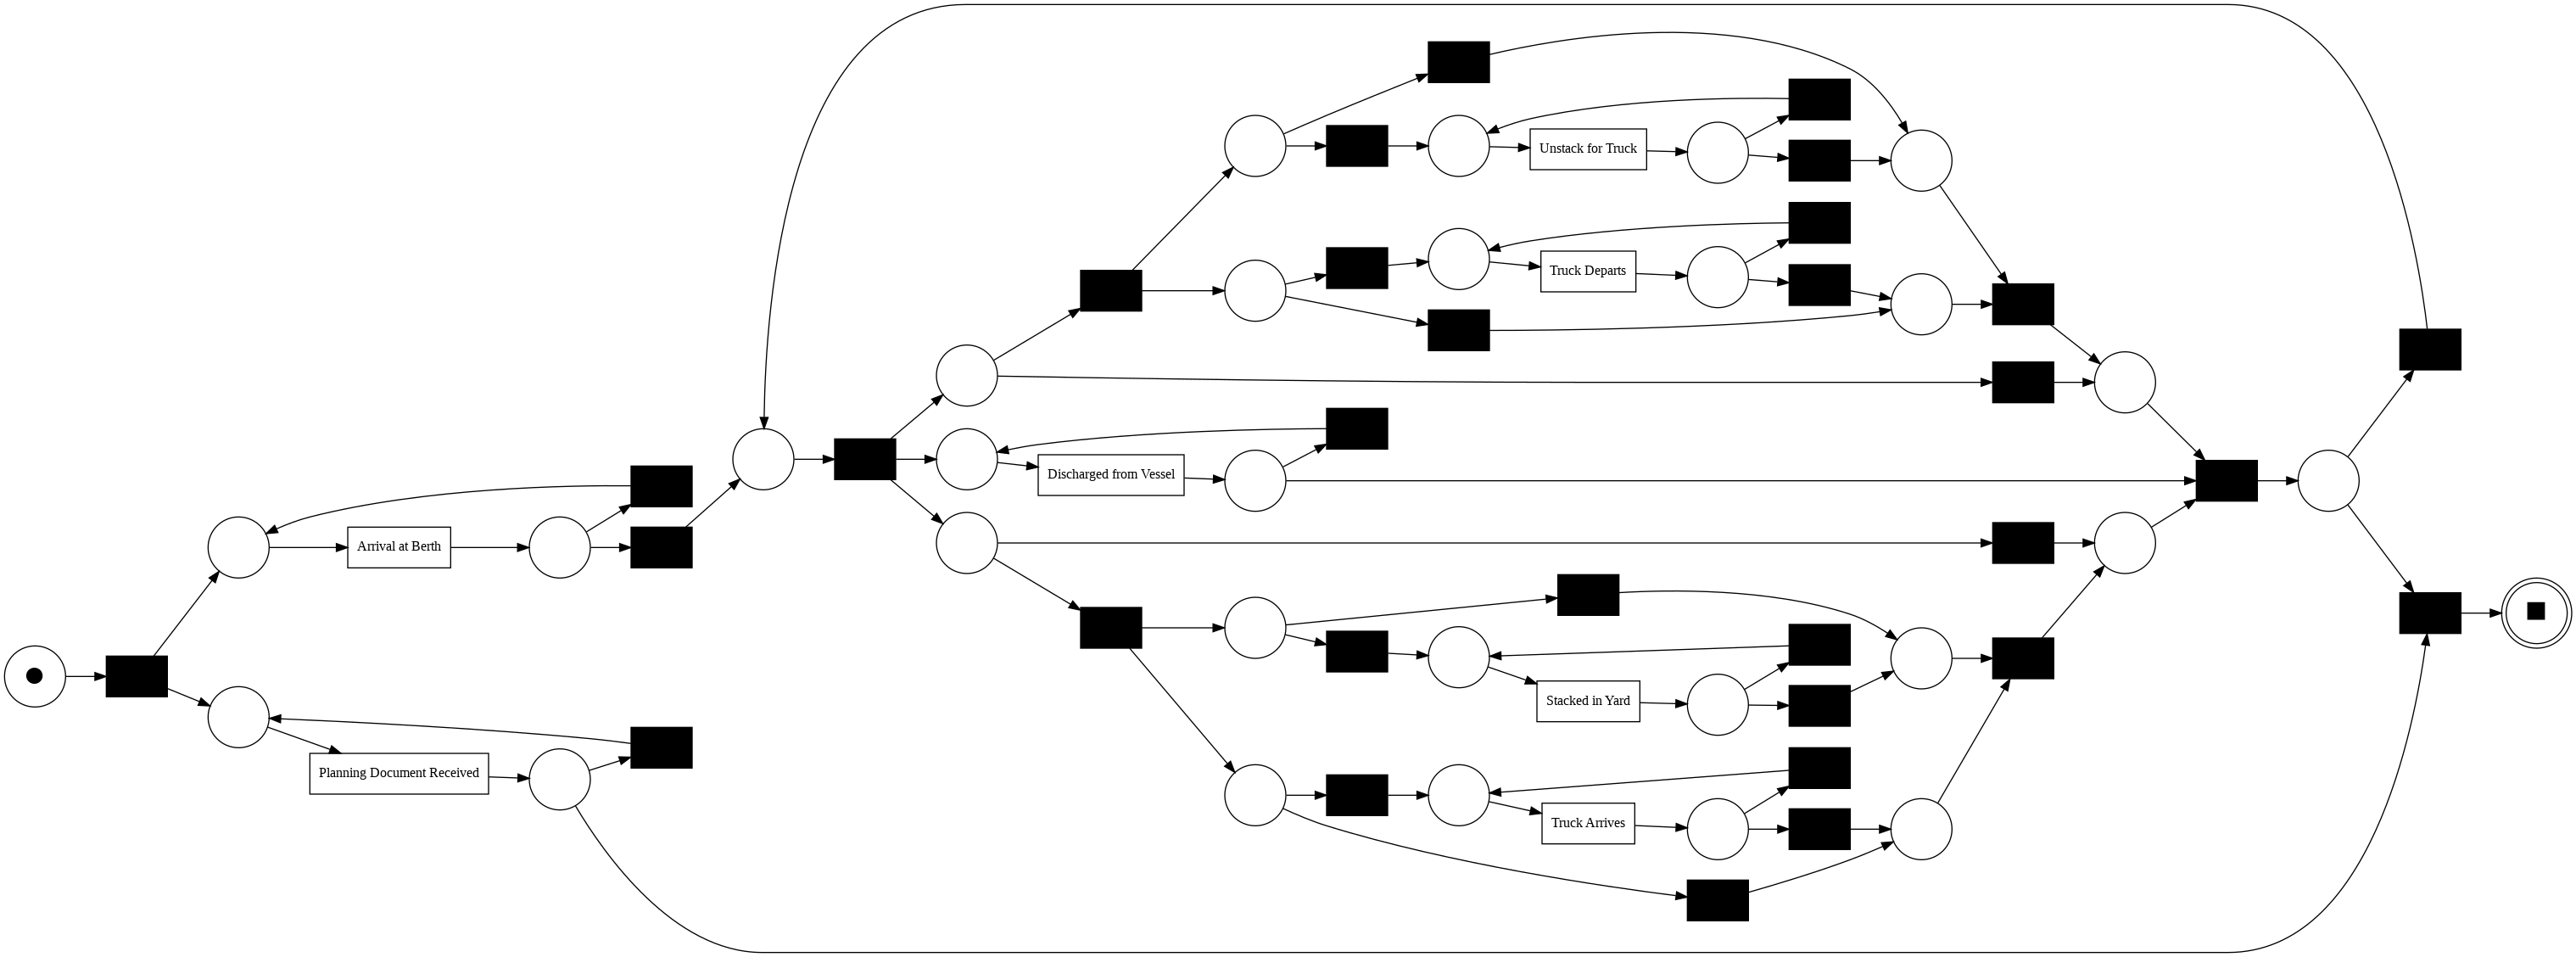

In [ ]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.conversion.process_tree import converter as tree_to_petri
from pm4py.visualization.petri_net import visualizer as pn_visualizer

# Discovery dengan Inductive Miner
tree = inductive_miner.apply(event_log, variant=inductive_miner.Variants.IM)

# Konversi ke Petri net dan visualisasi
net, im, fm = tree_to_petri.apply(tree)
gviz = pn_visualizer.apply(net, im, fm)
pn_visualizer.view(gviz)


In [ ]:
from pm4py.statistics.traces.generic.log import case_statistics
from pm4py.statistics.start_activities.log import get as start_activities
from pm4py.statistics.end_activities.log import get as end_activities

# Hitung jumlah kasus (unik case ID)
print("Jumlah kasus:", len(set([trace.attributes["concept:name"] for trace in event_log])))

# Aktivitas awal
start_acts = start_activities.get_start_activities(event_log)
print("Aktivitas awal:", start_acts)

# Aktivitas akhir
end_acts = end_activities.get_end_activities(event_log)
print("Aktivitas akhir:", end_acts)

# Trace paling umum
variants_count = case_statistics.get_variant_statistics(event_log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
print("Trace paling umum:", variants_count[0])


Jumlah kasus: 236
Aktivitas awal: {'Planning Document Received': 234, 'Arrival at Berth': 2}
Aktivitas akhir: {'Stacked in Yard': 1, 'Truck Departs': 235}
Trace paling umum: {'variant': ('Planning Document Received', 'Arrival at Berth', 'Discharged from Vessel', 'Stacked in Yard', 'Truck Arrives', 'Unstack for Truck', 'Truck Departs'), 'count': 10}


In [24]:
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

xes_exporter.apply(event_log, "event_log_tps.xes")


exporting log, completed traces ::   0%|          | 0/236 [00:00<?, ?it/s]

In [25]:
from google.colab import files
files.download("event_log_tps.xes")  # atau .csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
!pip install pm4py==2.7.15.2

In [34]:
from pm4py.algo.evaluation.performance_map import algorithm as performance_map
from pm4py.visualization.performance_map import visualizer as perf_vis

perf_result = performance_map.apply(event_log)
gviz_perf = perf_vis.apply(perf_result)
perf_vis.view(gviz_perf)

ModuleNotFoundError: No module named 'pm4py.algo.evaluation.performance_map'